In [2]:
import sys
import os

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

DOWNLOAD = False

if DOWNLOAD:
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    output = "IT_data.h5"
    gdown.download(url, output, quiet=False, fuzzy=True)

## 0. Load data

In [6]:
path_to_data = ''
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape

## 1. Prediction from pixels

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate,KFold

X_train = stimulus_train.reshape(stimulus_train.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
X_val_scaled = scaler.fit_transform(X_val)

pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

X_train_pca.shape,X_val_pca.shape

((2592, 1000), (288, 1000))

### 1.1 Linear regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_pca, spikes_train)

pearson_corr_lr = np.zeros(n_neurons)
predictions_val_lr = lr.predict(X_val_pca)
for i in range(n_neurons):
    pearson_corr_lr[i] = np.corrcoef(predictions_val_lr[:, i], spikes_val[:, i])[0, 1]
explained_var_lr = explained_variance_score(spikes_val, predictions_val_lr, multioutput='raw_values')

print("Linear Regression")
print("Pearson correlation: ", np.mean(pearson_corr_lr))
print("Explained variance: ", np.mean(explained_var_lr))

Linear Regression
Pearson correlation:  0.221168866209307
Explained variance:  -0.0724655691356886


### 1.2 Ridge regression

In [ ]:
# Perform k-fold cross-validation to find the best alpha for Ridge regression.

def find_best_alpha_ridge(X, y, candidate_alphas=None, n_splits=5, scoring='explained_variance'):
    if candidate_alphas is None:
        candidate_alphas = np.logspace(-2,5,5)

    best_alpha = None
    best_score = -np.inf

    for alpha in candidate_alphas:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=888)
        fold_scores = []

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val_cv = y[train_idx], y[val_idx]

            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)

            if scoring == 'explained_variance':
                score = np.mean([
                    explained_variance_score(y_val_cv[:, n], preds[:, n])
                    for n in range(y.shape[1])
                ])
            elif scoring == 'correlation':
                score = np.mean([
                    np.corrcoef(preds[:, n], y_val_cv[:, n])[0, 1]
                    for n in range(y.shape[1])
                ])
            else:
                raise ValueError("Invalid scoring. Use 'explained_variance' or 'correlation'.")

            fold_scores.append(score)

        avg_score = np.mean(fold_scores)
        print(f"Alpha {alpha:.1e} -> CV {scoring}: {avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_alpha = alpha

    print(f"✅ Best alpha: {best_alpha:.1e} with CV {scoring}: {best_score:.4f}")
    return best_alpha


In [ ]:
best_alpha = find_best_alpha_ridge(X_train_pca, spikes_train, candidate_alphas=None, n_splits=5, scoring='explained_variance')
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_pca, spikes_train)
predictions_val_ridge = ridge.predict(X_val_pca)
pearson_corr_ridge = np.zeros(n_neurons)
for i in range(n_neurons):
    pearson_corr_ridge[i] = np.corrcoef(predictions_val_ridge[:, i], spikes_val[:, i])[0, 1]
explained_var_ridge = explained_variance_score(spikes_val, predictions_val_ridge, multioutput='raw_values')
print("Ridge Regression")
print("Pearson correlation: ", np.mean(pearson_corr_ridge))
print("Explained variance: ", np.mean(explained_var_ridge))

Alpha 1.0e-02 -> CV explained_variance: -1.3631
Alpha 5.6e-01 -> CV explained_variance: -1.3627
Alpha 3.2e+01 -> CV explained_variance: -1.3410
Alpha 1.8e+03 -> CV explained_variance: -0.7186
Alpha 1.0e+05 -> CV explained_variance: 0.0600
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.0600
Ridge Regression
Pearson correlation:  0.2739008283023446
Explained variance:  0.08147349208593369


### 1.3 Brief conclusion
Ridge regression performs slightly better than naive linear regression. Hence we established our regression model: after extracting first 1000 PCs, then perform Ridge regression with the best alpha value found by grid search.

## 2. Task-driven approach

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate,KFold
from tqdm import tqdm
import gc
import pickle
from torch.nn import init
from torch.nn import Parameter
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

y_train = spikes_train
y_val = spikes_val

In [8]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA available: Yes")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA available: No")

PyTorch version: 2.7.0+cu118
CUDA available: Yes
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4090 Laptop GPU


### 2.1 Define functions to extract layer activation

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.get_hook(layer_id))

    def get_hook(self, layer_id):
        def hook(module, input, output):
            self._features[layer_id] = output
        return hook

    def forward(self, x):
        self.model(x)
        return [self._features[layer_id] for layer_id in self.layers]

In [ ]:
# Convert HxWxC numpy images to CxHxW torch tensors
def preprocess_images(images):
    # Images are already normalized in the dataset
    # Convert to torch tensor and adjust dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Our images are already in the format [batch, channels, height, width]
    return images_tensor

# Extract features layerwise from the model
def extract_features(model, stimulus, layers_to_extract, batch_size=128):
    # Create feature extractor
    extractor = FeatureExtractor(model, layers_to_extract)
    extractor.to(device)
    extractor.eval()

    results = {}

    # Process one layer at a time
    for layer_name in layers_to_extract:
        print(f"\nProcessing layer: {layer_name}")

        # Create DataLoader
        dataset = TensorDataset(preprocess_images(stimulus))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # Collect activations
        layer_activations = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Extracting {layer_name}"):
                batch = batch[0].to(device)
                # Call the entire model to get all activations
                activations = extractor(batch)
                # Find the index of the current layer
                layer_idx = layers_to_extract.index(layer_name)
                # Get activations for the current layer
                layer_act = activations[layer_idx].cpu().numpy()

                # Flatten
                if len(layer_act.shape) > 2:
                    if layer_name == 'avgpool':
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)
                    else:
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)

                layer_activations.append(layer_act)

        # Combine batches
        layer_act = np.vstack(layer_activations)

        # Store original features
        results[layer_name] = {
            'features': layer_act
        }

        # ===============
        # clean up memory
        del layer_activations, layer_act
        gc.collect()
        torch.cuda.empty_cache()

    # Clean up extractor
    del extractor
    gc.collect()
    torch.cuda.empty_cache()

    return results

# Perform PCA on the extracted features
def apply_pca_to_features(train_features, val_features, layers_to_extract, n_components=1000):
    train_pcs = {}
    val_pcs = {}

    for layer_name in layers_to_extract:
        X_train = train_features[layer_name]['features']
        X_val = val_features[layer_name]['features']

        # If n_components is greater than or equal to the feature dimensions, skip PCA
        if n_components >= X_train.shape[1]:
            print(f"Layer {layer_name}: Skipping PCA as n_components ({n_components}) >= feature dimensions ({X_train.shape[1]})")
            train_pcs[layer_name] = {
                'pcs': X_train,
                'scaler': None,
                'pca': None
            }
            val_pcs[layer_name] = {
                'pcs': X_val
            }
            continue

        # the X_train is now embeddings
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        # X_train_scaled = X_train
        # X_val_scaled = X_val

        n_comp = min(n_components, X_train.shape[0], X_train.shape[1])
        pca = PCA(n_components=n_comp)
        train_pcs[layer_name] = {
            'pcs': pca.fit_transform(X_train_scaled),
            # 'scaler': scaler,
            'pca': pca
        }

        val_pcs[layer_name] = {
            'pcs': pca.transform(X_val)
        }

        print(f"Layer {layer_name}: {n_comp} components, {sum(pca.explained_variance_ratio_):.4f} variance explained")

    return train_pcs, val_pcs

### 2.2 Initialize pretrained model

In [11]:
need_to_extract_pca = "True"
# What model you want to use?
# resnet18, resnet50, vit or random for unpretrained model
my_model = "resnet50"
# my_model = "alexnet"
# my_model = "mobilenet"
# my_model = "vgg16"
# my_model = "vit"
# my_model = "resnet18"
# my_model = "random"

In [14]:
# =============================
# Model Selection Block (MobileNetV2, VGG16, AlexNet, DenseNet121, ResNet18, ViT)
# =============================
from torchvision.models import (
    mobilenet_v2, vgg16, alexnet, densenet121,
    resnet18, vit_b_16,resnet50
)

device = "cuda" if torch.cuda.is_available() else "cpu"

if my_model == "mobilenet":
    print("Using MobileNetV2 pretrained model")
    pretrained_model = mobilenet_v2(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.0',
        'features.3',
        'features.6',
        'features.10',
        'features.14',
        'features.18',
    ]

elif my_model == "vgg16":
    print("Using VGG16 pretrained model")
    pretrained_model = vgg16(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.4',
        'features.9',
        'features.16',
        'features.23',
        'features.30'
    ]

elif my_model == "alexnet":
    print("Using AlexNet pretrained model")
    pretrained_model = alexnet(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.0',   # conv1
        'features.2',
        'features.5',
        'features.12'
    ]


elif my_model == "resnet18":
    print("Using ResNet18 pretrained model")
    pretrained_model = resnet18(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

elif my_model == "resnet50":
    print("Using ResNet50 pretrained model")
    pretrained_model = resnet50(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

elif my_model == "vit":
    print("Using Vision Transformer (ViT-B/16) pretrained model")
    pretrained_model = vit_b_16(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    # ViT has a flat structure, so just one key representation layer
    layers_to_extract = [
        'conv_proj',
        'encoder',
        'heads',
    ]

elif my_model == "random":
    print("Using Randomly Initialized Model")
    random_model = resnet50(pretrained=False)
    random_model.to(device)
    random_model.eval()
    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

else:
    raise ValueError("Unsupported model type. Choose from: resnet50, alexnet, mobilenet, vgg16, vit, resnet18, random")

Using ResNet50 pretrained model


### 2.3 (Optional) Fine-tune pretrained Model
Use pretrained ResNet50 to fine-tune.

% ================================================================

ONLY RUN IF YOU WANT TO DO FPFT (classification)

% ===============================================================

#### 2.3.1 Preparation
Encode fine-tuning labels，get the pretrained model and load the data.

In [15]:
# Encoding of the labels
y_ft_train = objects_train
y_ft_val = objects_val
unique_classes = sorted(list(set(y_ft_train) | set(y_ft_val)))
num_classes = len(unique_classes)
print(f"Number of unique classes: {num_classes}")
class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
y_ft_train = np.array([class_to_idx[cls] for cls in objects_train])
y_ft_val = np.array([class_to_idx[cls] for cls in objects_val])

Number of unique classes: 64


In [16]:
model_name = "resnet50" # only resnet50 for now
resnet50 = getattr(models, model_name)(weights='IMAGENET1K_V1')
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, num_classes)

resnet50.eval()  # Set to evaluation mode
resnet50 = resnet50.to(device)

In [17]:
# Define batch size
batch_size = 128

# Create training dataset and dataloader
train_dataset = TensorDataset(
    preprocess_images(stimulus_train),
    torch.tensor(y_ft_train, dtype=torch.long)
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Create evaluation dataset and dataloader
eval_dataset = TensorDataset(
    preprocess_images(stimulus_val),
    torch.tensor(y_ft_val, dtype=torch.long)
)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False
)

#### 2.3.2 Fine-tune the model with our data

In [19]:
def train_model(model, train_dataloader, eval_dataloader, y_train, y_val, criterion,
                num_epochs, device, warmup_epochs=5, lr_start=0.001, lr_max=0.01, lr_min=0.000001,
                patience=30, min_delta=0.001):
    # Lists to store metrics
    train_losses = []
    val_accuracies = []

    # Initialize optimizer with starting learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_start)

    # Use a more aggressive learning rate scheduler
    # ReduceLROnPlateau reduces LR when a metric has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,     # Reduce LR by half when triggered
        patience=5,     # Number of epochs with no improvement after which LR will be reduced
        min_lr=lr_min
    )

    # Early stopping variables
    best_val_mse = float('inf')
    counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)

        # Evaluation phase
        model.eval()

        with torch.no_grad():
            all_preds = []
            total_mse = 0.0
            num_batches = 0

            for inputs, targets in eval_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate MSE
                batch_mse = criterion(outputs, targets).item()
                total_mse += batch_mse
                num_batches += 1

                # Store predictions for further analysis if needed
                all_preds.append(outputs.cpu().numpy())

        # Calculate average MSE over all validation batches
        val_mse = total_mse / num_batches
        val_accuracies.append(-val_mse)  # Store negative MSE so higher is better in plots

        # Step the scheduler based on validation loss
        scheduler.step(val_mse)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        print(f'Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}, Loss: {epoch_loss:.4f}, Validation MSE: {val_mse:.4f}')

        # Early stopping check
        if val_mse < best_val_mse - min_delta:
            best_val_mse = val_mse
            counter = 0
            # Save the best model state
            best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                # Load the best model state
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break

    return train_losses, val_accuracies


In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 1000
train_losses, val_accuracies = train_model(
    model=resnet50,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    y_train=y_ft_train,
    y_val=y_ft_val,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    patience=20
)

Epoch 1/1000, LR: 0.001000, Loss: 2.4172, Validation MSE: 2.8423
Epoch 2/1000, LR: 0.001000, Loss: 1.2135, Validation MSE: 2.0082
Epoch 3/1000, LR: 0.001000, Loss: 0.8243, Validation MSE: 1.7051
Epoch 4/1000, LR: 0.001000, Loss: 0.6554, Validation MSE: 2.0308
Epoch 5/1000, LR: 0.001000, Loss: 0.5471, Validation MSE: 1.2237
Epoch 6/1000, LR: 0.001000, Loss: 0.3892, Validation MSE: 1.2735
Epoch 7/1000, LR: 0.001000, Loss: 0.2987, Validation MSE: 2.0124
Epoch 8/1000, LR: 0.001000, Loss: 0.3226, Validation MSE: 0.9785
Epoch 9/1000, LR: 0.001000, Loss: 0.3055, Validation MSE: 1.9488
Epoch 10/1000, LR: 0.001000, Loss: 0.2562, Validation MSE: 1.9946
Epoch 11/1000, LR: 0.001000, Loss: 0.2111, Validation MSE: 1.1725
Epoch 12/1000, LR: 0.001000, Loss: 0.1483, Validation MSE: 1.1293
Epoch 13/1000, LR: 0.001000, Loss: 0.1757, Validation MSE: 2.2956
Epoch 14/1000, LR: 0.000500, Loss: 0.1402, Validation MSE: 1.0351
Epoch 15/1000, LR: 0.000500, Loss: 0.0671, Validation MSE: 0.6780
Epoch 16/1000, LR: 

In [ ]:
# save the model
filename = "resnet50_fpft_classification.pth"
print("Selected model name is ", filename)
torch.save(resnet50.state_dict(), filename)
print(f"Model saved successfully to {filename}")
pretrained_model = resnet50
use_fpft = True

Selected model name is  resnet50_fpft_classification.pth
Model saved successfully to resnet50_fpft_classification.pth


#### 2.3.3 Load fine-tuned model if exists

In [22]:
 # load it from shared drive
filename = "resnet50_fpft_classification.pth"

pretrained_model = getattr(models, "resnet50")(weights='IMAGENET1K_V1')
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, num_classes)
pretrained_model = pretrained_model.to(device)

# Load the saved state dict
pretrained_model.load_state_dict(torch.load(filename))
pretrained_model.eval()
pretrained_model = pretrained_model.to(device)
print(f"Model loaded successfully from '{filename}'")
use_fpft = True

Model loaded successfully from 'resnet50_fpft_classification.pth'


### 2.4 Obtain activation and perform PCA per layer

In [23]:
need_to_extract_pca # if you dont have the pcs file, train it (its very large)

'True'

In [24]:
if need_to_extract_pca=="True":
    if my_model != "random":
        print("Extracting features from pre-trained model...")
        pretrained_features_train = extract_features(pretrained_model, stimulus_train, layers_to_extract, batch_size=64)
        pretrained_features_val = extract_features(pretrained_model, stimulus_val, layers_to_extract, batch_size=64)
    else:
        print("Extracting features from randomly initialized model...")
        random_features_train = extract_features(random_model, stimulus_train, layers_to_extract, batch_size=64)
        random_features_val = extract_features(random_model, stimulus_val, layers_to_extract, batch_size=64)
else:
    print("No need to extract features")

Extracting features from pre-trained model...

Processing layer: conv1


Extracting conv1: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 41/41 [00:06<00:00,  6.58it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 41/41 [00:04<00:00,  8.41it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 41/41 [00:04<00:00,  9.41it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 41/41 [00:03<00:00, 11.53it/s]



Processing layer: conv1


Extracting conv1: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 5/5 [00:00<00:00, 12.95it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


In [25]:
if need_to_extract_pca == "True":
    print(f"Extracting PCA from {my_model} model...")
    #if my_model == "pretrained":
    if my_model != "random":
        pretrained_pcs_train, pretrained_pcs_val = apply_pca_to_features(
            pretrained_features_train,
            pretrained_features_val,
            layers_to_extract,
            n_components=1000
        )
    else:
        random_pcs_train, random_pcs_val = apply_pca_to_features(
            random_features_train,
            random_features_val,
            layers_to_extract,
            n_components=1000
        )
else:
    print("No need to extract PCA from features")

Extracting PCA from resnet50 model...
Layer conv1: 1000 components, 0.8670 variance explained
Layer layer1: 1000 components, 0.7558 variance explained
Layer layer2: 1000 components, 0.6940 variance explained
Layer layer3: 1000 components, 0.6749 variance explained
Layer layer4: 1000 components, 0.9761 variance explained


In [ ]:
# # pca_name = "fpft_pretrained_scaled_pcs.pkl" if already_scaled else "fpft_pretrained_pcs.pkl"
# pca_name = "restnet50_fpft_classification_pcs.pkl"
# print("Loading PCA results...")
# with open(pca_name, 'rb') as f:
#     pretrained_pcs_train, pretrained_pcs_val = pickle.load(f)

In [27]:
def predict_neural_activity(layer_pcs_train, layer_pcs_val, y_train, y_val, sample_to_plot=0):
    layer_metrics = {}
    sample_predictions = {}

    for layer_name in layers_to_extract:
        print(f"Predicting neural activity using {layer_name}")
        X_train_pcs = layer_pcs_train[layer_name]['pcs']
        X_val_pcs = layer_pcs_val[layer_name]['pcs']


        if X_train_pcs.shape[1] != X_val_pcs.shape[1]:
            print(f"Warning: Feature mismatch for {layer_name}. Training: {X_train_pcs.shape[1]}, Validation: {X_val_pcs.shape[1]}")
            min_components = min(X_train_pcs.shape[1], X_val_pcs.shape[1])
            X_train_pcs = X_train_pcs[:, :min_components]
            X_val_pcs = X_val_pcs[:, :min_components]
            print(f"Using {min_components} components for both sets")

        correlations = []
        exp_variances = []
        sample_neuron_predictions = []  # Store predictions for all neurons for a specific sample

        best_alpha = find_best_alpha_ridge(X_train_pcs, y_train, candidate_alphas=np.logspace(-2,5,10), n_splits=5, scoring='explained_variance')
        lr = Ridge(alpha=best_alpha)
        lr.fit(X_train_pcs, y_train)

        y_pred = lr.predict(X_val_pcs)
        y_true = y_val

            # Calculate correlation and explained variance
        for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            correlation = np.corrcoef(y_pred[:,neuron], y_true[:,neuron])[0, 1]
            exp_var = explained_variance_score(y_true[:,neuron], y_pred[:,neuron])

            correlations.append(correlation)
            exp_variances.append(exp_var)

            # Save prediction for the specific sample
            sample_neuron_predictions.append(y_pred[sample_to_plot,neuron])

        layer_metrics[layer_name] = {
            'correlations': correlations,
            'exp_variances': exp_variances,
            'mean_correlation': np.mean(correlations),
            'mean_exp_variance': np.mean(exp_variances)
        }

        sample_predictions[layer_name] = np.array(sample_neuron_predictions)

        print(f"Mean correlation for {layer_name}: {np.mean(correlations):.4f}")
        print(f"Mean explained variance for {layer_name}: {np.mean(exp_variances):.4f}")


    # PLOT a single case just to visualize... not that meaningful tho

    # Plot predictions for all neurons from each layer for a specific sample
    plt.figure(figsize=(14, 7))

    plt.figure(figsize=(14, 7))
    neurons = np.arange(y_val.shape[1])
    plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)

    colors = plt.cm.tab10(np.linspace(0, 1, len(layers_to_extract)))
    for i, layer_name in enumerate(layers_to_extract):
        plt.plot(neurons, sample_predictions[layer_name], 'o-', color=colors[i], label=f'{layer_name} Prediction', alpha=0.8)

    plt.title(f'Neural Activity Predictions for Sample {sample_to_plot}')
    plt.xlabel('Neuron Number')
    plt.ylabel('Neural Activity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('all_layer_predictions.png')
    plt.show()

    return layer_metrics

Predicting with pre-trained model features...
Predicting neural activity using conv1
Alpha 1.0e-02 -> CV explained_variance: -2.6444
Alpha 6.0e-02 -> CV explained_variance: -2.6444
Alpha 3.6e-01 -> CV explained_variance: -2.6444
Alpha 2.2e+00 -> CV explained_variance: -2.6441
Alpha 1.3e+01 -> CV explained_variance: -2.6424
Alpha 7.7e+01 -> CV explained_variance: -2.6321
Alpha 4.6e+02 -> CV explained_variance: -2.5722
Alpha 2.8e+03 -> CV explained_variance: -2.2622
Alpha 1.7e+04 -> CV explained_variance: -1.2890
Alpha 1.0e+05 -> CV explained_variance: -0.2658
✅ Best alpha: 1.0e+05 with CV explained_variance: -0.2658


Training models for conv1: 100%|██████████| 168/168 [00:00<00:00, 1741.66it/s]

Mean correlation for conv1: 0.2661
Mean explained variance for conv1: -0.0071
Predicting neural activity using layer1


Alpha 1.0e-02 -> CV explained_variance: -0.7667
Alpha 6.0e-02 -> CV explained_variance: -0.7667
Alpha 3.6e-01 -> CV explained_variance: -0.7667
Alpha 2.2e+00 -> CV explained_variance: -0.7666
Alpha 1.3e+01 -> CV explained_variance: -0.7663
Alpha 7.7e+01 -> CV explained_variance: -0.7647
Alpha 4.6e+02 -> CV explained_variance: -0.7550
Alpha 2.8e+03 -> CV explained_variance: -0.7014
Alpha 1.7e+04 -> CV explained_variance: -0.4780
Alpha 1.0e+05 -> CV explained_variance: -0.0475
✅ Best alpha: 1.0e+05 with CV explained_variance: -0.0475


Training models for layer1: 100%|██████████| 168/168 [00:00<00:00, 1763.41it/s]

Mean correlation for layer1: 0.5022
Mean explained variance for layer1: 0.0764
Predicting neural activity using layer2


Alpha 1.0e-02 -> CV explained_variance: -0.4917
Alpha 6.0e-02 -> CV explained_variance: -0.4917
Alpha 3.6e-01 -> CV explained_variance: -0.4917
Alpha 2.2e+00 -> CV explained_variance: -0.4916
Alpha 1.3e+01 -> CV explained_variance: -0.4914
Alpha 7.7e+01 -> CV explained_variance: -0.4898
Alpha 4.6e+02 -> CV explained_variance: -0.4803
Alpha 2.8e+03 -> CV explained_variance: -0.4284
Alpha 1.7e+04 -> CV explained_variance: -0.2257
Alpha 1.0e+05 -> CV explained_variance: 0.1125
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.1125


Training models for layer2: 100%|██████████| 168/168 [00:00<00:00, 3891.25it/s]

Mean correlation for layer2: 0.5349
Mean explained variance for layer2: 0.0788
Predicting neural activity using layer3


Alpha 1.0e-02 -> CV explained_variance: -1.1103
Alpha 6.0e-02 -> CV explained_variance: -1.1103
Alpha 3.6e-01 -> CV explained_variance: -1.1102
Alpha 2.2e+00 -> CV explained_variance: -1.1098
Alpha 1.3e+01 -> CV explained_variance: -1.1072
Alpha 7.7e+01 -> CV explained_variance: -1.0916
Alpha 4.6e+02 -> CV explained_variance: -1.0059
Alpha 2.8e+03 -> CV explained_variance: -0.6651
Alpha 1.7e+04 -> CV explained_variance: -0.0714
Alpha 1.0e+05 -> CV explained_variance: 0.2734
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.2734


Training models for layer3: 100%|██████████| 168/168 [00:00<00:00, 3021.11it/s]

Mean correlation for layer3: 0.5863
Mean explained variance for layer3: 0.0629
Predicting neural activity using layer4


Alpha 1.0e-02 -> CV explained_variance: -6.5136
Alpha 6.0e-02 -> CV explained_variance: -6.5098
Alpha 3.6e-01 -> CV explained_variance: -6.4831
Alpha 2.2e+00 -> CV explained_variance: -6.3424
Alpha 1.3e+01 -> CV explained_variance: -5.6131
Alpha 7.7e+01 -> CV explained_variance: -3.4296
Alpha 4.6e+02 -> CV explained_variance: -1.1293
Alpha 2.8e+03 -> CV explained_variance: -0.0636
Alpha 1.7e+04 -> CV explained_variance: 0.2485
Alpha 1.0e+05 -> CV explained_variance: 0.2993
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.2993


Training models for layer4: 100%|██████████| 168/168 [00:00<00:00, 1244.77it/s]


Mean correlation for layer4: 0.5463
Mean explained variance for layer4: 0.3070


<Figure size 1400x700 with 0 Axes>

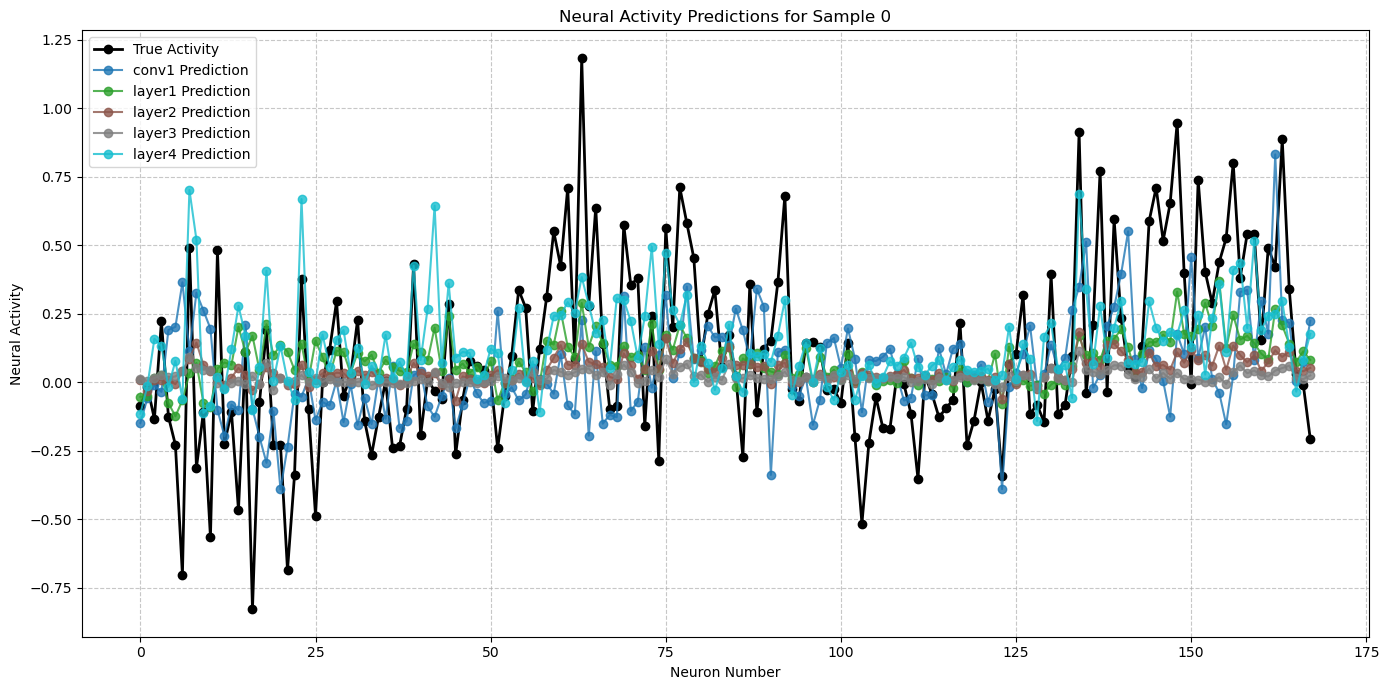

In [28]:
#if my_model == "pretrained":
if my_model != "random":
    print("Predicting with pre-trained model features...")
    layer_metrics = predict_neural_activity(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val)
else:
    print("Predicting with randomly initialized model features...")
    layer_metrics = predict_neural_activity(random_pcs_train, random_pcs_val, y_train, y_val)

### 2.5 Save the statistics of nerual activity prediction

In [ ]:
# Define a custom JSON encoder for metrics
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.generic):
            return obj.item()
        return super().default(obj)

In [31]:
use_fpft

True

In [32]:
if use_fpft:
    filename = f"{my_model}_fpft_classification_layer_metrics.json"
else:
    filename = f"{my_model}_layer_metrics.json"
print(f"saving to {filename}")


with open(filename, "w") as f:
    json.dump(layer_metrics, f, cls=NumpyEncoder, indent=2)

saving to resnet50_fpft_classification_layer_metrics.json


## 3. Data-driven aproach

### 3.1 Define dataloader for training

In [7]:
class SpikeData(Dataset):
    def __init__(self,stimulus,spike = None):
        self.stimulus = torch.tensor(stimulus)

        if spike is not None:
          self.spike = torch.tensor(spike)
          self.num_neuron = self.spike.shape[1]
        else:
          self.spike = None
          self.num_neuron = None

    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        if self.spike is not None:
            return self.stimulus[idx], self.spike[idx]
        else:
            return self.stimulus[idx]

In [8]:
ITdataloader_train = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=True)
ITdataloader_val = DataLoader(SpikeData(stimulus_val, spikes_val), batch_size=64, shuffle=False)

### 3.2. Build shallow CNN for strike prediction

In [9]:
class ShallowCNN(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 64 * (224 // 8) * (224 // 8)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod
    @torch.no_grad()
    def init_weights(module):
        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [10]:
class ToyMobilenet(nn.Module):
    def __init__(self, num_neuron):
        super(ToyMobilenet, self).__init__()
        self.model = nn.Sequential(
            # Initial Convolutional Block 1
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU6(inplace=True),

            # Convolutional Block 2
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # Convolutional Block 3
            nn.Conv2d(16, 32, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(32),

            # First Inverted Residual Block
            nn.Conv2d(32, 64, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 32, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(32),

            # Convolutional Block 4 (downsampling to 16x16)
            nn.Conv2d(32, 64, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            # Convolutional Block 5
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),

            # Convolutional Block 6
            nn.Conv2d(128, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),

            # Second Inverted Residual Block
            nn.Conv2d(128, 256, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(128),

            # Final Expansion and Projection Layer
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, num_neuron)
        )

    def forward(self, x):
        out = self.model(x)
        return out

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad()
    def init_weights(module):
        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

### 3.3. Train models

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for stimulus, spikes in train_loader:
            stimulus, spikes = stimulus.to(device), spikes.to(device)
            optimizer.zero_grad()

            outputs = model(stimulus)
            loss = criterion(outputs, spikes)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss/len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step(val_loss)

        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)

    return model

In [ ]:
loss_fn = nn.MSELoss()
my_model = "shallowcnn" # or toymobilenet
if my_model == "shallowcnn":
    model = ShallowCNN(num_neuron=n_neurons)
    model.apply(ShallowCNN.init_weights)
elif my_model == "toymobilenet":
    model = ToyMobilenet(num_neuron=n_neurons)
    model.apply(ToyMobilenet.init_weights)
else:
    raise ValueError("Unsupported model type. Choose from: 'shallowcnn', 'toymobilenet'")

model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
if my_model == "toymobilenet":
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5)
else:
    scheduler = None

train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=200, scheduler=scheduler)

if my_model == "shallowcnn":
    save_path = 'shallow_cnn.pth'
elif my_model == "toymobilenet":
    save_path = 'toy_mobilenet.pth'


torch.save(model.state_dict(), save_path)

Epoch 1/200, Train Loss: 1220.3192, Val Loss: 52.1399
Epoch 2/200, Train Loss: 55.7255, Val Loss: 15.5890
Epoch 3/200, Train Loss: 29.2568, Val Loss: 11.3038
Epoch 4/200, Train Loss: 20.7403, Val Loss: 8.8014
Epoch 5/200, Train Loss: 16.1316, Val Loss: 6.3047
Epoch 6/200, Train Loss: 12.7852, Val Loss: 5.6858
Epoch 7/200, Train Loss: 10.7937, Val Loss: 4.6450
Epoch 8/200, Train Loss: 8.6484, Val Loss: 3.9277
Epoch 9/200, Train Loss: 7.4899, Val Loss: 3.6405
Epoch 10/200, Train Loss: 6.6765, Val Loss: 3.2618
Epoch 11/200, Train Loss: 6.1251, Val Loss: 2.9832
Epoch 12/200, Train Loss: 5.3260, Val Loss: 2.6624
Epoch 13/200, Train Loss: 4.7025, Val Loss: 2.3787
Epoch 14/200, Train Loss: 4.1894, Val Loss: 2.1981
Epoch 15/200, Train Loss: 3.9730, Val Loss: 1.9653
Epoch 16/200, Train Loss: 3.5196, Val Loss: 1.7839
Epoch 17/200, Train Loss: 3.2743, Val Loss: 1.7073
Epoch 18/200, Train Loss: 3.0047, Val Loss: 1.4952
Epoch 19/200, Train Loss: 2.7344, Val Loss: 1.4947
Epoch 20/200, Train Loss: 2.

In [ ]:
loss_fn = nn.MSELoss()
my_model = "toymobilenet"
if my_model == "shallowcnn":
    model = ShallowCNN(num_neuron=n_neurons)
    model.apply(ShallowCNN.init_weights)
elif my_model == "toymobilenet":
    model = ToyMobilenet(num_neuron=n_neurons)
    model.apply(ToyMobilenet.init_weights)
else:
    raise ValueError("Unsupported model type. Choose from: 'shallowcnn', 'toymobilenet'")

model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
if my_model == "toymobilenet":
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5)
else:
    scheduler = None

train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=200, scheduler=scheduler)

if my_model == "shallowcnn":
    save_path = 'shallow_cnn.pth'
elif my_model == "toymobilenet":
    save_path = 'toy_mobilenet.pth'


torch.save(model.state_dict(), save_path)

Epoch 1/200, Train Loss: 0.1827, Val Loss: 0.1418
Epoch 2/200, Train Loss: 0.1347, Val Loss: 0.1373
Epoch 3/200, Train Loss: 0.1324, Val Loss: 0.1345
Epoch 4/200, Train Loss: 0.1299, Val Loss: 0.1324
Epoch 5/200, Train Loss: 0.1267, Val Loss: 0.1325
Epoch 6/200, Train Loss: 0.1245, Val Loss: 0.1715
Epoch 7/200, Train Loss: 0.1227, Val Loss: 0.1268
Epoch 8/200, Train Loss: 0.1197, Val Loss: 0.1239
Epoch 9/200, Train Loss: 0.1167, Val Loss: 0.1226
Epoch 10/200, Train Loss: 0.1151, Val Loss: 0.2717
Epoch 11/200, Train Loss: 0.1115, Val Loss: 0.1134
Epoch 12/200, Train Loss: 0.1094, Val Loss: 0.4021
Epoch 13/200, Train Loss: 0.1081, Val Loss: 0.1123
Epoch 14/200, Train Loss: 0.1070, Val Loss: 0.3747
Epoch 15/200, Train Loss: 0.1055, Val Loss: 0.1086
Epoch 16/200, Train Loss: 0.1041, Val Loss: 0.1303
Epoch 17/200, Train Loss: 0.1031, Val Loss: 0.1219
Epoch 18/200, Train Loss: 0.1019, Val Loss: 0.1119
Epoch 19/200, Train Loss: 0.1007, Val Loss: 0.1032
Epoch 20/200, Train Loss: 0.0997, Val Lo

### 3.4. Evaluation of the model

In [ ]:
load = True
load_path = 'shallow_cnn.pth'
my_model = "shallowcnn" # or toymobilenet

if load:
    if my_model == "shallowcnn":
        model = ShallowCNN(num_neuron=n_neurons)
    elif my_model == "toymobilenet":
        model = ToyMobilenet(num_neuron=n_neurons)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [21]:
model.eval()

prediction_train = []

ITdataloader_train_pred = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=False)

with torch.no_grad():
    for stimulus, _ in ITdataloader_train_pred:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_train.append(outputs.cpu())

prediction_train = torch.cat(prediction_train, dim=0)


prediction_val = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_val:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_val.append(outputs.cpu())

prediction_val = torch.cat(prediction_val, dim=0)


In [22]:
pearson_corr_dd = np.zeros(n_neurons)
for i in range(n_neurons):
    pearson_corr_dd[i] = np.corrcoef(prediction_val[:, i], spikes_val[:, i])[0, 1]
explained_var_dd = explained_variance_score(spikes_val, prediction_val, multioutput='raw_values')
print(f"Data-driven model: {my_model}")
print("Pearson correlation: ", np.mean(pearson_corr_dd))
print("Explained variance: ", np.mean(explained_var_dd))

Data-driven model: toymobilenet
Pearson correlation:  0.5722046847787096
Explained variance:  0.342399


### 3.5 Save the metrics

In [ ]:
dd_metrics = {
    'correlations': pearson_corr_dd.tolist(),
    'exp_variances': explained_var_dd.tolist(),
    'mean_correlation': np.mean(pearson_corr_dd),
    'mean_exp_variance': np.mean(explained_var_dd)
}

filename = "toymobilenet_metrics.json"
with open(filename, "w") as f:
    json.dump(dd_metrics, f, cls=NumpyEncoder, indent=2)

## 4. Hybrid Method
This is the best model we have. We used pretrained ResNet50 to predict neural activity directly. The model expects input as stimuli images and will output the prediction of IT neural activity dircetly. 

### 4.1 Fine-tune the model with spike data

In [ ]:
model_name = "resnet50"
resnet50 = getattr(models, model_name)(weights='IMAGENET1K_V1')

num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, n_neurons)

resnet50.eval()  # Set to evaluation mode
resnet50 = resnet50.to(device)

In [ ]:
batch_size = 128

# Create training dataset and dataloader
train_dataset = TensorDataset(
    preprocess_images(stimulus_train),
    torch.tensor(y_train, dtype=torch.float32)
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Create evaluation dataset and dataloader
eval_dataset = TensorDataset(
    preprocess_images(stimulus_val),
    torch.tensor(y_val, dtype=torch.float32)
)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
def train_model(model, train_dataloader, eval_dataloader, y_train, y_val, criterion,
                num_epochs, device, warmup_epochs=2, lr_start=0.001, lr_max=0.01, lr_min=0.000001,
                patience=50, min_delta=0.001):
    # Lists to store metrics
    train_losses = []
    val_accuracies = []

    # Initialize optimizer with starting learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_start)

    # Use a more aggressive learning rate scheduler
    # ReduceLROnPlateau reduces LR when a metric has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,     # Reduce LR by half when triggered
        patience=5,     # Number of epochs with no improvement after which LR will be reduced
        min_lr=lr_min
    )

    # Early stopping variables
    best_val_mse = float('inf')
    counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)

        # Evaluation phase
        model.eval()

        with torch.no_grad():
            all_preds = []
            total_mse = 0.0
            num_batches = 0

            for inputs, targets in eval_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate MSE
                batch_mse = criterion(outputs, targets).item()
                total_mse += batch_mse
                num_batches += 1

                # Store predictions for further analysis if needed
                all_preds.append(outputs.cpu().numpy())

        # Calculate average MSE over all validation batches
        val_mse = total_mse / num_batches
        val_accuracies.append(-val_mse)  # Store negative MSE so higher is better in plots

        # Step the scheduler based on validation loss
        scheduler.step(val_mse)

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']

        print(f'Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}, Loss: {epoch_loss:.4f}, Validation MSE: {val_mse:.4f}')

        # Early stopping check
        if val_mse < best_val_mse - min_delta:
            best_val_mse = val_mse
            counter = 0
            # Save the best model state
            best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                # Load the best model state
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break

    return train_losses, val_accuracies


In [ ]:
criterion = nn.MSELoss()
num_epochs = 1000

train_losses, val_accuracies = train_model(
    model=resnet50,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    y_train=y_train,
    y_val=y_val,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    patience=20
)

Epoch 1/1000, LR: 0.001000, Loss: 0.1599, Validation MSE: 0.2275
Epoch 2/1000, LR: 0.001000, Loss: 0.1130, Validation MSE: 0.1375
Epoch 3/1000, LR: 0.001000, Loss: 0.1030, Validation MSE: 0.1100
Epoch 4/1000, LR: 0.001000, Loss: 0.0930, Validation MSE: 0.0973
Epoch 5/1000, LR: 0.001000, Loss: 0.0846, Validation MSE: 0.0956
Epoch 6/1000, LR: 0.001000, Loss: 0.0771, Validation MSE: 0.0863
Epoch 7/1000, LR: 0.001000, Loss: 0.0718, Validation MSE: 0.0807
Epoch 8/1000, LR: 0.001000, Loss: 0.0653, Validation MSE: 0.0791
Epoch 9/1000, LR: 0.001000, Loss: 0.0608, Validation MSE: 0.0901
Epoch 10/1000, LR: 0.001000, Loss: 0.0571, Validation MSE: 0.0823
Epoch 11/1000, LR: 0.001000, Loss: 0.0541, Validation MSE: 0.0744
Epoch 12/1000, LR: 0.001000, Loss: 0.0510, Validation MSE: 0.0736
Epoch 13/1000, LR: 0.001000, Loss: 0.0492, Validation MSE: 0.0748
Epoch 14/1000, LR: 0.001000, Loss: 0.0461, Validation MSE: 0.0728
Epoch 15/1000, LR: 0.001000, Loss: 0.0445, Validation MSE: 0.0707
Epoch 16/1000, LR: 

In [ ]:
filename = "resnet50_fpft_spike.pth"
torch.save(resnet50.state_dict(), filename)
print(f"Model saved successfully to {filename}")

Model saved successfully to resnet50_fpft_spike.pth


In [ ]:
# Load
resnet50.load_state_dict(torch.load(filename))
resnet50.eval()  # Set the model to evaluation mode
print(f"Model loaded successfully from '{filename}'")

Model loaded successfully from 'resnet50_fpft_spike.pth'


### 4.2 Evaluation of the fine-tuned model on validation set

In [ ]:
def evaluate_model(model, eval_dataloader, y_val, device):
    model.eval()  # Set to evaluation mode

    all_predictions = []

    with torch.no_grad():
        for batch in eval_dataloader:
            if isinstance(batch, list):
                # If it's a list, assume the first element is the input
                inputs = batch[0]
            elif isinstance(batch, tuple):
                inputs = batch[0]
            else:
                inputs = batch

            if not isinstance(inputs, torch.Tensor):
                inputs = torch.tensor(inputs, dtype=torch.float32)

            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())

    predictions = np.vstack(all_predictions)

    # Ensure predictions and ground truth have the same number of samples
    if predictions.shape[0] > y_val.shape[0]:
        predictions = predictions[:y_val.shape[0]]
    elif predictions.shape[0] < y_val.shape[0]:
        y_val = y_val[:predictions.shape[0]]

    # Calculate correlation and explained variance for each neuron
    correlations = []
    exp_variances = []

    for neuron in range(y_val.shape[1]):
        y_true = y_val[:, neuron]
        y_pred = predictions[:, neuron]

        # Calculate correlation
        correlation = np.corrcoef(y_pred, y_true)[0, 1]
        correlations.append(correlation)

        # Calculate explained variance
        exp_var = explained_variance_score(y_true, y_pred)
        exp_variances.append(exp_var)

    # Calculate averages and standard deviations
    mean_correlation = np.mean(correlations)
    std_correlation = np.std(correlations)
    mean_exp_variance = np.mean(exp_variances)
    std_exp_variance = np.std(exp_variances)

    print(f"Mean Correlation: {mean_correlation:.4f} ± {std_correlation:.4f}")
    print(f"Mean Explained Variance: {mean_exp_variance:.4f} ± {std_exp_variance:.4f}")

    # Visualize overall results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Plot correlations without sorting
    plt.plot(range(len(correlations)), correlations, 'o-', markersize=3)
    plt.axhline(mean_correlation, color='r', linestyle='--')
    plt.title(f'Correlation Distribution (Mean: {mean_correlation:.4f})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Correlation')

    plt.subplot(1, 2, 2)
    # Plot explained variances without sorting
    plt.plot(range(len(exp_variances)), exp_variances, 'o-', markersize=3)
    plt.axhline(mean_exp_variance, color='r', linestyle='--')
    plt.title(f'Explained Variance Distribution (Mean: {mean_exp_variance:.4f})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Explained Variance')

    plt.tight_layout()
    plt.show()

    return predictions, correlations, exp_variances, mean_correlation, mean_exp_variance

Mean Correlation: 0.6677 ± 0.1438
Mean Explained Variance: 0.4612 ± 0.1744


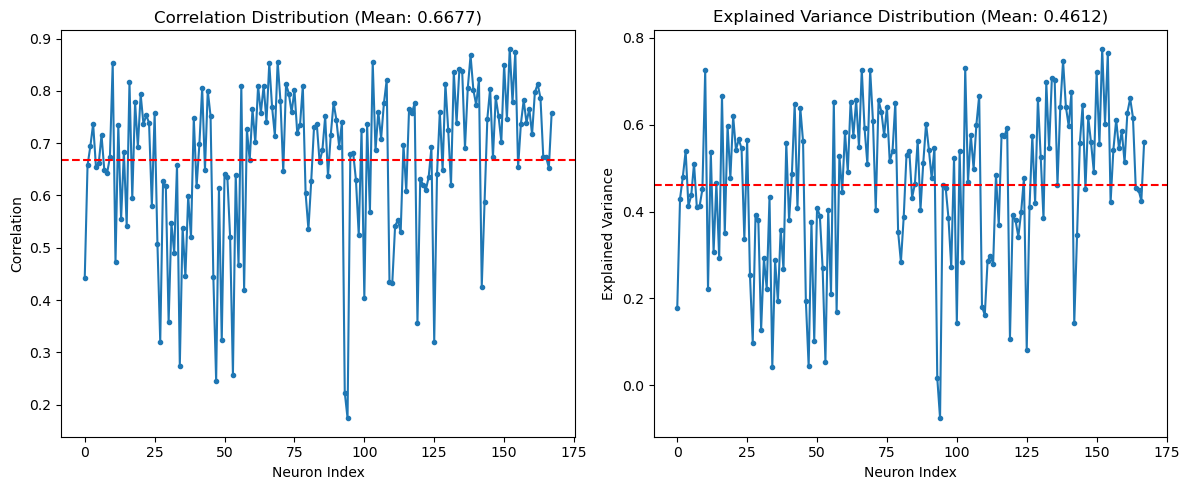

In [ ]:
predictions, correlations, exp_variances, mean_correlation, mean_exp_variance = evaluate_model(
    model=resnet50,
    eval_dataloader=eval_dataloader,
    y_val=y_val,
    device=device
)

In [ ]:
hybrid_metrics = {
    'correlations': correlations,
    'exp_variances': exp_variances,
    'mean_correlation': np.mean(correlations),
    'mean_exp_variance': np.mean(exp_variances)
}

filename = "hybrid_metrics.json"
with open(filename, "w") as f:
    json.dump(hybrid_metrics, f, cls=NumpyEncoder, indent=2)